In [1]:
%load_ext autoreload
%autoreload 2

from src.rxn_ctr_mcs import *
from src.utils import load_json, rxn_entry_to_smarts
from src.pathway_utils import get_reverse_paths_to_starting, create_graph_from_pickaxe
from src.post_processing import *

from minedatabase.pickaxe import Pickaxe
from minedatabase.utils import get_compound_hash

from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import csv

/home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at /home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.LayerNorm.bias', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expec

In [2]:
# Set params

expansion_dir = '../data/raw_expansions/'
fn = "succinate_to_mvacid_gen_4_tan_sample_n_samples_1000.pk" # Expansion file name
generations = 4

# Load results
pk = Pickaxe()
path = expansion_dir + fn
pk.load_pickled_pickaxe(path)

----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading ../data/raw_expansions/succinate_to_mvacid_gen_4_tan_sample_n_samples_1000.pk pickled data.
Loaded 89758 compounds
Loaded 106853 reactions
Loaded 3604 operators
Loaded 1 targets
Took 6.671696424484253


In [3]:
# Create the initial graph

DG, rxn, edge = create_graph_from_pickaxe(pk, "Biology")
starting_nodes = []
bad_nodes = []
for n in DG.nodes():
    try:
        if DG.nodes()[n]["Type"] == "Starting Compound":
            starting_nodes.append(n)
    except:
        bad_nodes.append(n)

RDKit ERROR: [15:53:22] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34
RDKit ERROR: 
[15:53:22] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34

RDKit ERROR: [15:53:23] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34
[15:53:23] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34

RDKit ERROR: 
RDKit ERROR: [15:53:31] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34
RDKit ERROR: 
[15:53:31] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34

RDKit ERROR: [15:53:32] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34
RDKit ERROR: 
[15:53:32] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34

RDKit ERROR: [15:53:32] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34
RDKit ERROR: 
[15:53:32] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34

RDKit ERROR: [15:53:32] Can't kekulize mol.  Unkek

In [4]:
# Get pathways
max_depth = generations * 2
paths = []

# Specify Targets / Starting Cpds
target_smi = pk.target_smiles[0]
target_cids = [get_compound_hash(smi)[0] for smi in pk.target_smiles]
starting_cpds = [get_compound_hash(val["SMILES"])[0] for val in pk.compounds.values() if val["Type"].startswith("Start")]

# Loop through targets and get pathways from targets to starting compounds
for this_target in target_cids:
    this_paths = get_reverse_paths_to_starting(DG, begin_node=this_target, end_nodes=starting_cpds, max_depth=max_depth)
    # If we find paths then reverse those paths and assign to a dictionary
    if this_paths:
        this_paths = list(set([tuple(path[1::2]) for path in [[*reversed(ind_path)] for ind_path in this_paths]]))
        for elt in this_paths:
            for r in pk.reactions[elt[0]]["Reactants"]:
                if r[-1] in starting_cpds:
                    paths.append(pathway(rhashes=elt, starter_hash=r[-1], target_hash=this_target)) 

In [5]:
# Make predicted reaction dict

pred_rxns = {}
degen_rhashes = defaultdict(lambda : 1)
for elt in paths:
    for this_rhash in elt.rhashes:
        if this_rhash not in pred_rxns:
            rxn_sma = rxn_hash_2_rxn_sma(this_rhash, pk)
            pred_rxns[this_rhash] = reaction(this_rhash, rxn_sma)
        else:
            degen_rhashes[this_rhash] += 1


In [6]:
# Put paths in dict indexed by starter-target pairs
# target_id_2_name = {'Cec77ea281f69ca989bbef0a4c7794128a196c716': '2-methyleneglutarate',
#                     'C3a5b833f1a5abe2063ff8b22706fabb74097bead': '4-methyleneglutamate'}
target_id_2_name = {'C6ec1611229ff4fc7a19244967c7716266fc021a1': 'mvacid'}

st_paths = defaultdict(list)
for elt in paths:
    t_name = target_id_2_name[elt.target]
    s_name = pk.compounds[elt.starter]["ID"]
    st_paths[(s_name, t_name)].append(elt)

for k,v in st_paths.items():
    print(k, len(v))

('succinate', 'mvacid') 41


In [7]:
# Load in IMT rule mapping

# Load rules
rules_path = '../src/rules/JN3604IMT_rules.tsv'
rule_df = pd.read_csv(rules_path, delimiter='\t')
rule_df.set_index('Name', inplace=True)

# Load mapping
rxn2rule = {}
db_names = ['_mc_v21', '_brenda', '_kegg']
suffix = '_imt_rules_enforce_cof.csv'
for name in db_names:
    mapping_path = '../data/mapping/mapping' + name + suffix
    with open(mapping_path, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if len(row) == 1:
                rxn2rule[row[0]] = []
            else:
                rxn2rule[row[0]] = row[1:]

# Make rule2rxn
rule2rxn = {}
for k,v in rxn2rule.items():
    for elt in v:
        if elt not in rule2rxn:
            rule2rxn[elt] = [k]
        else:
            rule2rxn[elt].append(k)

# Load all known reaction json entries into dict
known_rxns = {}
pref = '../data/mapping/'
suffs = ['mc_v21_as_is.json', 'brenda_as_is.json', 'kegg_as_is.json']
for elt in suffs:
    known_rxns.update(load_json(pref + elt))

In [8]:
# Populate reaction objects in rxn dict w/ known reactions

for k, v in pred_rxns.items():
    this_rules = list(pk.reactions[k]["Operators"])
    this_known_rxns = []
    for elt in this_rules:
        if elt in rule2rxn:
            this_rxn_ids = rule2rxn[elt]
            for this_id in this_rxn_ids:
                this_sma = rxn_entry_to_smarts(known_rxns[this_id])
                this_known_rxns.append((None, this_sma, this_id))
    
    v.known_rxns = [list(elt) for elt in set(this_known_rxns)]


In [9]:
# Populate pred_rxns, known rxn prc-mcs slot

for x in range(len(pred_rxns.keys())):
    h = list(pred_rxns.keys())[x]
    test_rxn = pred_rxns[h]
    a = 0 # Number known rxns analyszed
    for z, kr in enumerate(test_rxn.known_rxns):

        rxn_sma1 = test_rxn.smarts
        rxn_sma2 = kr[1]

        # Catch stoichiometry mismatches stemming from pickaxe, early post-processing
        if tuple([len(elt.split('.')) for elt in rxn_sma2.split('>>')]) != tuple([len(elt.split('.')) for elt in rxn_sma1.split('>>')]):
            print(x, z, 'stoich_error')
            continue

        # Skip pred reactions that trigger RXNMapper atom mapping errors
        try:
            am_rxn_smarts = [atom_map(rxn_sma1), atom_map(rxn_sma2)] # Atom map
        except:
            continue

        # Construct reaction objects
        rxns = []
        for elt in am_rxn_smarts:
            temp = AllChem.ReactionFromSmarts(elt, useSmiles=True)
            temp.Initialize()
            rxns.append(temp)

        rc_atoms = [elt.GetReactingAtoms() for elt in rxns] # Get reaction center atom idxs

        # Construct rxn ctr mol objs
        rcs = []
        for i, t_rxn in enumerate(rxns):
            temp = []
            for j, t_mol in enumerate(t_rxn.GetReactants()):
                temp.append(get_sub_mol(t_mol, rc_atoms[i][j]))
            rcs.append(temp)

        # Align substrates of the 2 reactions
        rc_idxs = [] # Each element: (idx for rxn 1, idx for rxn 2)
        remaining = [[i for i in range(len(elt))] for elt in rcs]
        while (len(remaining[0]) > 0) & (len(remaining[1]) > 0):
            idx_pair = align_substrates(rcs, remaining)

            if idx_pair is None:
                break
            else:
                rc_idxs.append(idx_pair)
                remaining[0].remove(idx_pair[0])
                remaining[1].remove(idx_pair[1])

        # Skip if you haven't aligned every reactant pred to known
        if len(rc_idxs) < len(rxn_sma1.split('>>')[0].split('.')):
            continue

        rxns = align_atom_map_nums(rxns, rcs, rc_idxs, rc_atoms)

        # Compute MCS seeded by reaction center
        prc_mcs = get_prc_mcs(rxns, rcs, rc_idxs, rc_atoms) 
        pred_rxns[h].known_rxns[z][0] = prc_mcs # Update pred_rxns
        
        a += 1

    print(x, ':', a / (z+1), 'out of', z+1)

Token indices sequence length is longer than the specified maximum sequence length for this model (703 > 512). Running this sequence through the model will result in indexing errors


0 : 0.15 out of 40
1 : 0.0 out of 9
2 : 0.6086956521739131 out of 23
3 : 0.13636363636363635 out of 88
4 : 0.723404255319149 out of 47
5 : 1.0 out of 20
6 : 0.6086956521739131 out of 23
7 : 0.6086956521739131 out of 23
8 : 0.0 out of 9
9 : 0.15 out of 40
10 : 1.0 out of 18
11 : 0.9310344827586207 out of 29
12 : 0.13636363636363635 out of 88
13 : 1.0 out of 24
14 : 0.13636363636363635 out of 88
15 : 0.13636363636363635 out of 88
16 : 1.0 out of 24
17 : 0.0 out of 88
18 : 0.15 out of 40
19 : 1.0 out of 9
20 : 1.0 out of 18
21 : 1.0 out of 9
22 : 1.0 out of 18
23 : 0.15 out of 40
24 : 0.13636363636363635 out of 88
25 : 0.15 out of 40
26 : 1.0 out of 20
27 : 0.0 out of 40
28 : 0.0 out of 9
29 : 0.723404255319149 out of 47
30 : 0.15 out of 40
31 : 0.13636363636363635 out of 88
32 : 0.9310344827586207 out of 29


In [10]:
# Save reactions dict (ultimately will replace with expansion object)

import pickle
rxns_fn = 'predicted_reactions_' + fn
save_dir = '../artifacts/'
path = save_dir + rxns_fn

with open(path, 'wb') as f:
    pickle.dump(pred_rxns, f)

with open(path, 'rb') as f:
    pred_rxns_loaded = pickle.load(f)

In [11]:
# Count how many pathways have full info

n_paths_w_full_info = 0
for p in paths:
    path_full_info = []
    for rh in p.rhashes:
        full_info = False
        for elt in pred_rxns_loaded[rh].known_rxns:
            if elt[0] is not None:
                full_info = True
                break

        path_full_info.append(full_info)
    
    if all(path_full_info):
        n_paths_w_full_info += 1

print(n_paths_w_full_info / len(paths), len(paths))


0.5365853658536586 41


In [30]:
# Sort known reactions by average (could alter the sort by value)
for k in pred_rxns_loaded.keys():
    pred_rxns_loaded[k].sort_known_rxns()

In [40]:
# Set prc mcs attribute for each path by averaging over 
# known reactions
for p in paths:
    p.compute_mean_prc_mcs(pred_rxns_loaded)

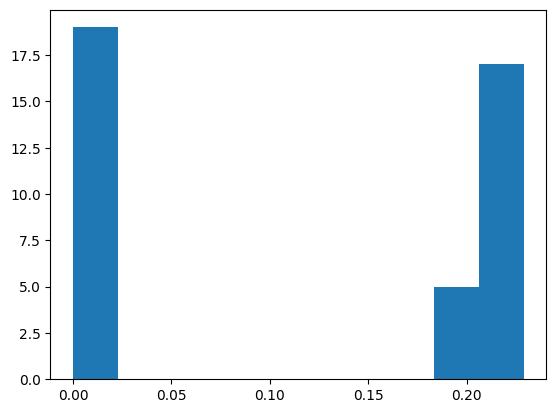

In [55]:
# Sort paths by min reaction prc mcs
min_prc_mcs = []
for p in paths:
    min_prc_mcs.append(p.min_mcs())

min_sorted_idxs = np.arange(len(paths))

min_sorted_idxs, min_prc_mcs = sort_x_by_y(min_sorted_idxs, min_prc_mcs, reverse=True)

plt.hist(min_prc_mcs)
plt.show()

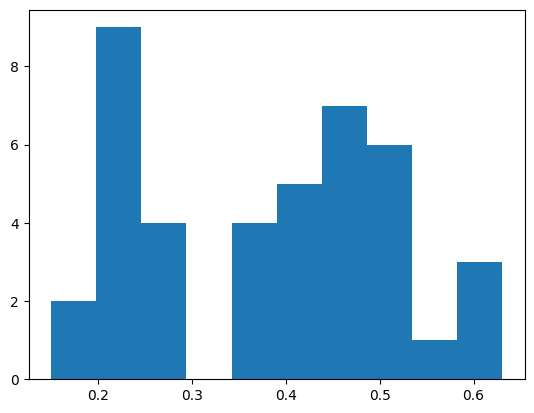

In [56]:
# Sort paths by min reaction prc mcs
mean_prc_mcs = []
for p in paths:
    mean_prc_mcs.append(p.mean_mcs())

mean_sorted_idxs = np.arange(len(paths))

mean_sorted_idxs, mean_prc_mcs = sort_x_by_y(mean_sorted_idxs, mean_prc_mcs, reverse=True)

plt.hist(mean_prc_mcs)
plt.show()

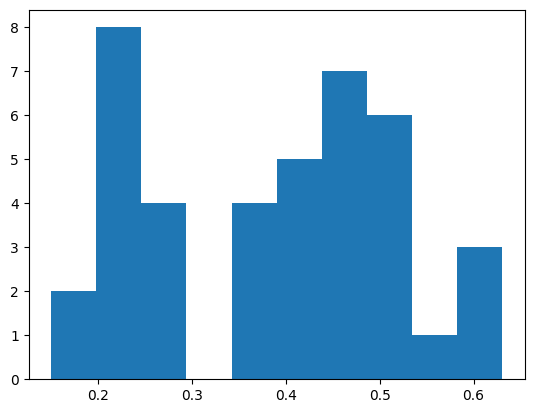

In [64]:
# First sort by min prc_mcs and then by mean prc_mcs

# Get min prc_mcs
min_prc_mcs = []
for p in paths:
    min_prc_mcs.append(p.min_mcs())

# Sort indices by min prc_mcs
min_sorted_idxs = np.arange(len(paths))
min_sorted_idxs, min_prc_mcs = sort_x_by_y(min_sorted_idxs, min_prc_mcs, reverse=True)

# Remove zero mins
min_sorted_idxs, min_prc_mcs = np.array(min_sorted_idxs), np.array(min_prc_mcs)
min_sorted_idxs = min_sorted_idxs[min_sorted_idxs > 0]

# Get mean prc_mcs of non-zero min paths
mean_prc_mcs = []
for idx in min_sorted_idxs:
    mean_prc_mcs.append(paths[idx].mean_mcs())

min_mean_sorted_idxs, mean_prc_mcs = sort_x_by_y(min_sorted_idxs, mean_prc_mcs, reverse=True)

plt.hist(mean_prc_mcs)
plt.show()

In [65]:
paths[min_mean_sorted_idxs[0]].rhashes

('Rc5cbbf9fe5a4d82c87a4b8c373b37a89e9d55d1bac64915b5f72f754cde5761c',
 'Rad6beda50733658265d3265a8a020e3e210b80972c361d5f4f8b5357de8a8103',
 'R66cd92f53f946853b98769c369a62c78dcef940f536f4861c868d2b1f68138ed',
 'Rbe282e0424c4e8a42e839a5c7c24529cdcb452119e633f3d0c3763342fa1a732')

In [70]:
pred_rxns_loaded['Rbe282e0424c4e8a42e839a5c7c24529cdcb452119e633f3d0c3763342fa1a732'].known_rxns

[[[1.0, 0.022727272727272728, 0.022727272727272728],
  'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1.CC(=O)O>>NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1.NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1.CCO.O',
  '1.1.1.1_309'],
 [[0.7, 0.022727272727272728, 0.022727272727272728],
  'NC(Cc1cnc[nH]1)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1>>NC(CO)Cc1cnc[nH]1.NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1.NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1.O',
  '1.1.1.23_1'],
 [[0.7, 0.022727272727272728, 0.022727272727272728],
  'NC(Cc1c[nH]cn1)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)

In [76]:
i = 1
j = 0
pred_known_pairs = []
example_path = paths[min_mean_sorted_idxs[i]].rhashes
for elt in example_path:
    this_pred = pred_rxns_loaded[elt]
    pred_img = draw_rxn(this_pred.smarts)
    known_img = draw_rxn(this_pred.known_rxns[j][1])
    pred_known_pairs.append([pred_img, known_img])

path_img = draw_pathway(pred_known_pairs)
path_img.save('../artifacts/test_concat.png')
    